# Apartment prices analysis in Serbia

Analysis is done on [this](https://www.kaggle.com/datasets/djordjejov/serbian-real-estate-dataset "kaggle dataset used") 2024 (march) dataset from Kaggle. For plotting data on map, libraries such as geopandas, geopy and folium are used.

In this project, we will analyse what is basically a "snapshot" of real estate market in Serbia at a given moment in time. We will implement different ideas such as plotting average square price per opstina (municipality), average square price in city Belgrade, create dot map (or marker map) where each dot is coloured with different color depending on square price, various graphs, heatmaps and so on.

This dataset should give a person the idea of real estate prices in different parts of Serbia. It can even be a rough guide when looking to buy new apartment. This analysis will provide a lot of important information such as:
* which municipalities in serbia are more expensive than others
* which parts of city are cheaper compared to others
* which part of city has cheap real estate and is close to city center
* which locations are more expensive
* how many apartments are for sale in different locations

This dataset does not include coordinates of apartments for sale. Later on, we will use custom geocoding heuristic methods to roughly approximate coordinates, which will help us create different kinds of maps.



#### Loading necessary libraries and setting global variables

In [1]:
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from pathlib import Path
from sys import stderr
import matplotlib.pyplot as plt
import seaborn as sb

DATA_DIR = Path.cwd() / 'data'

In [2]:
data = pd.read_csv(Path.cwd() / 'data' / 'apartmentsdata.csv')
data

,area,city,floor,location,price,rooms,source,square_price,title
0,76,Beograd,3,"Opština Vračar , Hram svetog Save , Svetog Save",290000,2.0,halooglasi,3816,"Plato Hrama Svetog Save, Vračar, 76m2"
1,41,Vrnjačka Banja,2,"Gradska lokacija , Raj , Kosovska br.1",82000,2.0,halooglasi,2000,Lux stan Akva Park Raj
2,37,Sokobanja,1,"Gradska lokacija , Banjica , Profesora Dragol...",60605,2.0,halooglasi,1650,Direktna prodaja stana u Sokobanji
3,34,Sokobanja,3,"Gradska lokacija , Banjica , Profesora Dragol...",59488,1.5,halooglasi,1760,Direktna prodaja stana Sokobanja
4,55,Beograd,2,"Opština Zemun , Altina , Ugrinovački put 8. deo",104500,2.0,halooglasi,1900,"Zemun, Altina, 2.0"
...,...,...,...,...,...,...,...,...,...
11699,49,Beograd,1,Zvezdara opština,105000,2.5,4zida,2143,Cvetanova Ćuprija
11700,39,Beograd,1,"Gornji Grad, Zemun, Zemun opština",105000,1.0,4zida,2692,Karlovačka
11701,81,Beograd,2,"Crveni Krst Vračar, Vračar",279449,3.5,4zida,3450,Gročanska
11702,92,Beograd,4,"Crveni Krst Vračar, Vračar",315254,3.5,4zida,3427,Gročanska


Let's analyze the dataset

In [3]:
data.shape

(11704, 9)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11704 entries, 0 to 11703
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          11704 non-null  int64  
 1   city          11704 non-null  object 
 2   floor         11586 non-null  object 
 3   location      11704 non-null  object 
 4   price         11704 non-null  int64  
 5   rooms         11704 non-null  float64
 6   source        11704 non-null  object 
 7   square_price  11704 non-null  int64  
 8   title         11704 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 823.1+ KB


There are 80 unique serbian cities in this dataset

In [5]:
data.nunique()

area              235
city               80
floor              31
location         3541
price            3292
rooms              14
source              2
square_price     2947
title           10371
dtype: int64

## Cleaning
We can immediately see a few problems with data. There is non-readable character in column "location" which is HTML artefact that occurred when data was scraped online. It is non-readable byte 0A. We will replace it with empty string.

It can also be noticed that there are 118 NaN values in column floor. We can remove those as well.

In [6]:
data = data.replace('\xa0', '', regex=True)
data

,area,city,floor,location,price,rooms,source,square_price,title
0,76,Beograd,3,"Opština Vračar, Hram svetog Save, Svetog Save",290000,2.0,halooglasi,3816,"Plato Hrama Svetog Save, Vračar, 76m2"
1,41,Vrnjačka Banja,2,"Gradska lokacija, Raj, Kosovska br.1",82000,2.0,halooglasi,2000,Lux stan Akva Park Raj
2,37,Sokobanja,1,"Gradska lokacija, Banjica, Profesora Dragolju...",60605,2.0,halooglasi,1650,Direktna prodaja stana u Sokobanji
3,34,Sokobanja,3,"Gradska lokacija, Banjica, Profesora Dragolju...",59488,1.5,halooglasi,1760,Direktna prodaja stana Sokobanja
4,55,Beograd,2,"Opština Zemun, Altina, Ugrinovački put 8. deo",104500,2.0,halooglasi,1900,"Zemun, Altina, 2.0"
...,...,...,...,...,...,...,...,...,...
11699,49,Beograd,1,Zvezdara opština,105000,2.5,4zida,2143,Cvetanova Ćuprija
11700,39,Beograd,1,"Gornji Grad, Zemun, Zemun opština",105000,1.0,4zida,2692,Karlovačka
11701,81,Beograd,2,"Crveni Krst Vračar, Vračar",279449,3.5,4zida,3450,Gročanska
11702,92,Beograd,4,"Crveni Krst Vračar, Vračar",315254,3.5,4zida,3427,Gročanska


In [7]:
data.isna().sum()

area              0
city              0
floor           118
location          0
price             0
rooms             0
source            0
square_price      0
title             0
dtype: int64

In [8]:
data.dropna(inplace=True)
data.isna().sum()

area            0
city            0
floor           0
location        0
price           0
rooms           0
source          0
square_price    0
title           0
dtype: int64

There are no duplicates

In [9]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
11699    False
11700    False
11701    False
11702    False
11703    False
Length: 11586, dtype: bool

Let's look for outliers. Minimum value in column square_price is 1, which will pollute our dataset

In [10]:
data.describe()

,area,price,rooms,square_price
count,11586.000000,1.158600e+04,11586.000000,11586.000000
mean,67.774124,1.652515e+05,2.576342,2370.175902
std,34.358166,1.456085e+05,1.093482,939.331849
min,14.000000,1.980000e+04,0.500000,1.000000
25%,45.000000,8.862500e+04,2.000000,1705.000000
50%,61.000000,1.287250e+05,2.500000,2237.000000
75%,81.000000,1.971350e+05,3.000000,2809.000000
max,885.000000,7.310888e+06,8.000000,9125.000000


Let's try to find flats that have price which is not logical

In [11]:
data.loc[data.square_price < 600]

,area,city,floor,location,price,rooms,source,square_price,title
1595,67,Zrenjanin,0.5,"Gradska lokacija, Zeleno Polje,",35000,3.0,halooglasi,522,"Zrenjanin, Zeleno Polje, Stan, 3.0, 67m2"
1803,61,Leskovac,p,"Gradska lokacija, Dubočica, Dubočica",36000,2.5,halooglasi,590,"Stan u kući u naselju Dubočica, 61m2, sa pomoćnim"
1952,68,Beograd,p,"Opština Lazarevac, Rudovci, Moše Pijade",23000,2.0,halooglasi,338,Lep dvosoban stan u koloniji Rudovci
2080,70,Svilajnac,p,"Gradska lokacija, Širi centar, Mišarska",35000,4.0,halooglasi,500,"Trosoban stan u Mišarskoj ulici,Svilajnac"
2376,75,Novi Sad,0,"Petrovaradin, Novi Majur",75000,2.0,halooglasi,1,***Novo u ponudi***
4005,99,Niš,0,"Palilula, Pasi poljana, Pasi poljana",45550,4.0,halooglasi,460,Stan u kući u Pasi Poljani
4049,170,Niš,0,"Palilula, 9. maj, Maršala Tita",53000,4.0,halooglasi,312,"Sprat kuće u Suvom Dolu, 170 m2 sa udelom u placu"
4149,135,Niš,0,"Palilula, Palilula, Dimitrija Tucovića",77000,4.0,halooglasi,570,"Odličan stan u kući kod železničke stanice, u ..."
4276,70,Apatin,p,"Gradska lokacija, Centar,",40000,2.0,halooglasi,571,"Komforan dvosoban stan 70m2, Iv sprat"
4443,62,Odžaci,4,"Gradska lokacija, Centar,",30000,2.0,halooglasi,484,"Stan U Odžacima na 4 spratu, 62 m2"


There is only one flat like that so we will remove it

In [12]:
data.drop(index=2376, inplace=True)

After removing rows, let's reset index values

In [13]:
data.reset_index(drop=True, inplace=True)

# Analysis

Data is scraped from 2 main sources, websites "halooglasi" and "4zida"

In [14]:
data['source'].value_counts()

source
halooglasi    9824
4zida         1761
Name: count, dtype: int64

Apartment prices include data from 80 different Serbian cities

In [15]:
data['city'].nunique()

80

In [16]:
data.describe()

,area,price,rooms,square_price
count,11585.000000,1.158500e+04,11585.000000,11585.000000
mean,67.773500,1.652593e+05,2.576392,2370.380406
std,34.359583,1.456124e+05,1.093516,939.114425
min,14.000000,1.980000e+04,0.500000,312.000000
25%,45.000000,8.870000e+04,2.000000,1705.000000
50%,61.000000,1.287500e+05,2.500000,2237.000000
75%,81.000000,1.971400e+05,3.000000,2809.000000
max,885.000000,7.310888e+06,8.000000,9125.000000


We can notice the following:
* average area is 67 square meters
* average price is 165.251 euro
* average price per square meter is 2370 euros
* median price is 128.725 euros
* median number of rooms is 2.5
* median price per square meter is 2237 euros
* most expensive flat has price of 9125 euros per square meter

## Location extraction

Let's first analyze location data from halooglasi

In [17]:
data.loc[data['source'] == 'halooglasi', ['city', 'location']]

,city,location
0,Beograd,"Opština Vračar, Hram svetog Save, Svetog Save"
1,Vrnjačka Banja,"Gradska lokacija, Raj, Kosovska br.1"
2,Sokobanja,"Gradska lokacija, Banjica, Profesora Dragolju..."
3,Sokobanja,"Gradska lokacija, Banjica, Profesora Dragolju..."
4,Beograd,"Opština Zemun, Altina, Ugrinovački put 8. deo"
...,...,...
9819,Niš,"Medijana, Dom zdravlja, Bulevar Nemanjića"
9820,Stara Pazova,"Gradska lokacija, Centar, Ćirila i Metodija"
9821,Beograd,"Opština Vračar, Kalenić pijaca, Hadži Prodanova"
9822,Niš,"Medijana, Centar, Generala Milojka Lešjanina"


Let's analyze okolna lokacija and planina

In [18]:
data.loc[(data['source'] == 'halooglasi') & (data['location'].str.contains('Planina') | data['location'].str.contains('Okolno mesto')), ['city', 'location']]

,city,location
5,Kopaonik,"Okolno mesto, Brzeće, Mramorska88"
32,Zlatibor,"Planina, Sloboda, Kiridžijska"
44,Kopaonik,"Planina, Centar, Jovana Cvijića 44 - Vila Nikola"
151,Tara,"Planina, Kaluđerske bare, Kremanske Kose"
197,Zlatibor,"Planina, Centar, Krfska"
...,...,...
9794,Kopaonik,"Planina, Čajetinska česma"
9801,Kopaonik,"Planina, Kraljevi čardaci, Miodraga Petrovića..."
9812,Zlatibor,"Planina, Centar,"
9814,Kopaonik,"Planina, Kraljevi čardaci,"


In [19]:
planine_opstina = {
    'kopaonik': 'brus',
    'zlatibor': 'čajetina',
    'tara': 'bajina bašta'
}

In [20]:
data.loc[data['source'] == '4zida', ['city', 'location']]

,city,location
9824,Beograd,"Meandri, Zemun, Zemun opština"
9825,Beograd,"Čukarica, Čukarica opština"
9826,Kruševac,Gradske lokacije
9827,Beograd,"Vojvode Stepe, Voždovac opština"
9828,Novi Sad,"Liman, Gradske lokacije"
...,...,...
11580,Beograd,Zvezdara opština
11581,Beograd,"Gornji Grad, Zemun, Zemun opština"
11582,Beograd,"Crveni Krst Vračar, Vračar"
11583,Beograd,"Crveni Krst Vračar, Vračar"


We will use shapefiles located in data/shapefiles for plotting. Data is downloaded from https://gadm.org/download_country.html.

Different files represent different levels of administrative division. For example gadm41_SRB_0.shp has borders of Serbia, gadm41_SRB_1 has borders of districts, gadm41_SRB_2.shp has borders of municipalities.

* municipality = opstina (in Serbian)
* district = okrug (in Serbian)

In [21]:
opstine_gdf = gpd.read_file(DATA_DIR / 'shapefiles' / 'gadm41_SRB_2.shp')
opstine_gdf # NAME_2 opstina, NAME_1 okrug

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,SRB.1.1_1,SRB,Serbia,SRB.1_1,Borski,Борски,Bor,NA,Бор,Opštine,Town|Municipal,NA,NA,"POLYGON ((21.95543 44.17786, 21.96122 44.17815..."
1,SRB.1.2_1,SRB,Serbia,SRB.1_1,Borski,Борски,Kladovo,Claudia|Kladowo,Кладово,Opštine,Town|Municipal,NA,NA,"POLYGON ((22.64921 44.54113, 22.64846 44.54166..."
2,SRB.1.3_1,SRB,Serbia,SRB.1_1,Borski,Борски,Majdanpek,NA,Мајданпек,Opštine,Town|Municipal,NA,NA,"POLYGON ((22.19147 44.49854, 22.19248 44.5, 22..."
3,SRB.1.4_1,SRB,Serbia,SRB.1_1,Borski,Борски,Negotin,NA,Неготин,Opštine,Town|Municipal,NA,NA,"MULTIPOLYGON (((22.68511 44.20988, 22.68508 44..."
4,SRB.2.1_1,SRB,Serbia,SRB.2_1,Braničevski,Браничевски,Golubac,Galambóc|Golumbácz|Güvercinlik,Голубац,Opštine,Town|Municipal,NA,NA,"POLYGON ((21.86947 44.6506, 21.87328 44.6498, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,SRB.25.6_1,SRB,Serbia,SRB.25_1,Zlatiborski,Златиборски,Požega,NA,Пожега,Opštine,Town|Municipal,NA,NA,"POLYGON ((20.00952 44.10419, 20.01237 44.10105..."
157,SRB.25.7_1,SRB,Serbia,SRB.25_1,Zlatiborski,Златиборски,Priboj,NA,Прибој,Opštine,Town|Municipal,NA,NA,"POLYGON ((19.18567 43.53515, 19.19204 43.539, ..."
158,SRB.25.8_1,SRB,Serbia,SRB.25_1,Zlatiborski,Златиборски,Prijepolje,NA,Пријепоље,Opštine,Town|Municipal,NA,NA,"POLYGON ((19.74372 43.15093, 19.73375 43.15038..."
159,SRB.25.9_1,SRB,Serbia,SRB.25_1,Zlatiborski,Златиборски,Sjenica,NA,Сјеница,Opštine,Town|Municipal,NA,NA,"POLYGON ((20.03372 42.98514, 20.0263 42.99331,..."


Let's first extract opstina names from shape data

In [22]:
map = gpd.read_file(DATA_DIR / 'shapefiles' / 'gadm41_SRB_2.shp')
opstine = set()
for o in map['NAME_2']:
    opstine.add(o.lower())
opstine

{'ada',
 'aleksandrovac',
 'aleksinac',
 'alibunar',
 'apatin',
 'aranđelovac',
 'arilje',
 'babušnica',
 'bajina bašta',
 'barajevo',
 'batočina',
 'bač',
 'bačka palanka',
 'bačka topola',
 'bački petrovac',
 'bela crkva',
 'bela palanka',
 'beočin',
 'bečej',
 'blace',
 'bogatić',
 'bojnik',
 'boljevac',
 'bor',
 'bosilegrad',
 'brus',
 'bujanovac',
 'crna trava',
 'despotovac',
 'dimitrovgrad',
 'doljevac',
 'gadžin han',
 'golubac',
 'gornji milanovac',
 'grocka',
 'inđija',
 'irig',
 'ivanjica',
 'jagodina',
 'kanjiža',
 'kikinda',
 'kladovo',
 'knić',
 'knjaževac',
 'koceljeva',
 'kosjerić',
 'kovačica',
 'kovin',
 'kragujevac',
 'kraljevo',
 'krupanj',
 'kruševac',
 'kula',
 'kuršumlija',
 'kučevo',
 'lajkovac',
 'lapovo',
 'lazarevac',
 'lebane',
 'leskovac',
 'ljig',
 'ljubovija',
 'loznica',
 'lučani',
 'majdanpek',
 'mali iđoš',
 'mali zvornik',
 'malo crniće',
 'medveđa',
 'merošina',
 'mionica',
 'mladenovac',
 'negotin',
 'niš',
 'nova crnja',
 'nova varoš',
 'novi beogr

Data scraped from different websites will have different patterns. Unfortunately this dataset is not consistent which will make things harder and more case handling will be required.

A lot of apartment sale datasets do not have coordinates as columns. Coordinates should either be scraped from website or calculated. In this section, we will focus on extracting municipality location without coordinates data, only by using text available in dataset.

In [23]:
def extract_opstina(row) ->str:
    location_data = [s.strip() for s in row['location'].split(',')]

    if row['source'] == 'halooglasi':
        s = location_data[0].lower().replace("opština", "").strip()
        if s in opstine:
            return s.title()
        if s in ['gradska lokacija', 'okolno mesto']:
            if row['city'].lower() in opstine:
                return row['city'].title()
            elif row['city'].lower() in planine_opstina:
                return planine_opstina[row['city'].lower()].title()
        if s == 'planina' and row['city'].lower() in planine_opstina:
            return planine_opstina[row['city'].lower()].title()
        if row['city'].lower() in opstine:
            return row['city'].title()
        print(f'Nepoznato: {location_data[0]} {row['city']}')
        return 'unknown'
    elif row['source'] == '4zida':
        s = location_data[-1].lower().replace("opština", "").strip()
        if s in opstine:
            return s.title()
        if s in ['gradske lokacije', 'okolne lokacije']:
            if row['city'].lower() in opstine:
                return row['city'].title()
            elif row['city'].lower() in planine_opstina:
                return planine_opstina[row['city'].lower()].title()
        if s.lower() in planine_opstina:
            return planine_opstina[row['city'].lower()].title()
        print(f'Nepoznato: {location_data[-1]} {row['city']}')
        return 'unknown'
    raise RuntimeError('Value in column source is not halooglasi or 4zida')

Now let's apply function to dataset and create new column called opstina

In [24]:
data['opstina'] = data.apply(extract_opstina, axis=1)
data['opstina'].value_counts()

Nepoznato: Gradska lokacija Vranjska Banja
Nepoznato: Gradska lokacija Petrovac na Mlavi
Nepoznato: Gradska lokacija Petrovac na Mlavi
Nepoznato: Fruška Gora Fruška Gora


opstina
Novi Sad            3125
Voždovac             795
Novi Beograd         786
Zvezdara             756
Niš                  697
                    ... 
Srbobran               1
Gornji Milanovac       1
Aleksandrovac          1
Novi Kneževac          1
Ljubovija              1
Name: count, Length: 92, dtype: int64

## Area vs square price

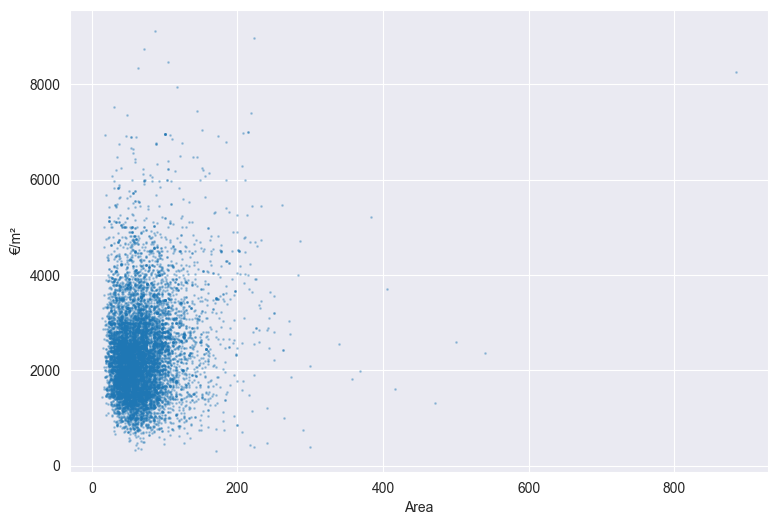

In [25]:
fig, ax = plt.subplots(figsize=(9,6))

ax.scatter(data['area'], data['square_price'], s=1, alpha=0.3)
ax.set_ylabel('€/m²')
ax.set_xlabel('Area')

plt.show()

There is no clear correlation between area and square price

There is one outlier, very large and very expensive apartment. It's located in Belgrade Waterfront (Beograd na vodi). We will keep it for now.

In [26]:
data.loc[data['area'] > 800]

,area,city,floor,location,price,rooms,source,square_price,title,opstina
56,885,Beograd,p,"Opština Savski venac, Beograd na vodi, Herceg...",7310888,6.0,halooglasi,8263,"BW Riviera, stan sa bazenom ID#9324",Savski Venac


#### Number of rooms vs area

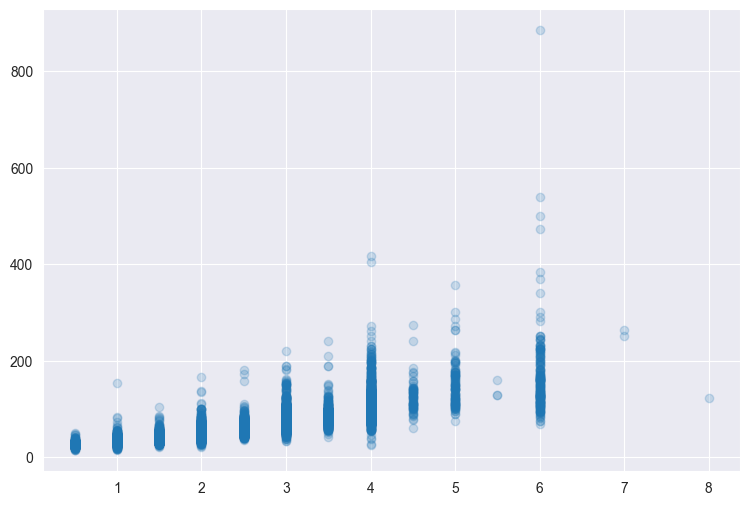

In [27]:
fig, ax = plt.subplots(figsize=(9,6))

ax.scatter(data['rooms'], data['area'], alpha=0.2)

plt.show()

intuitively, there is positive correlation between area and number of rooms

## Area distribution

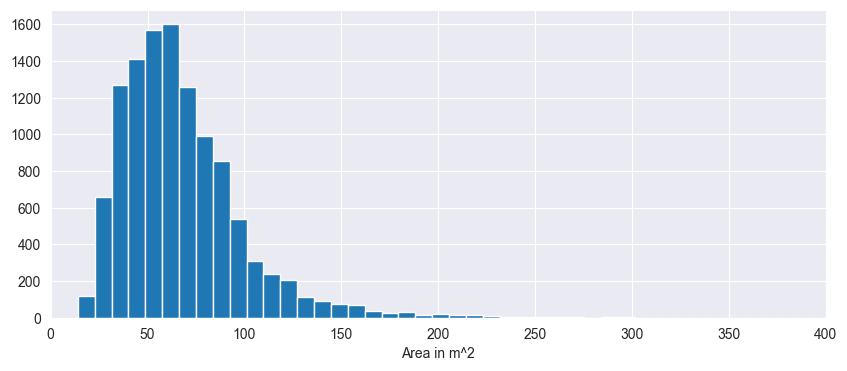

In [28]:
fig, ax = plt.subplots(figsize=(10,4))

ax.hist(data['area'], bins=100)
ax.set_xlim(0,400) # ignore outlier
ax.set_xlabel('Area in m^2')

plt.show()

## Square price analysis

#### square price distribution in Serbia

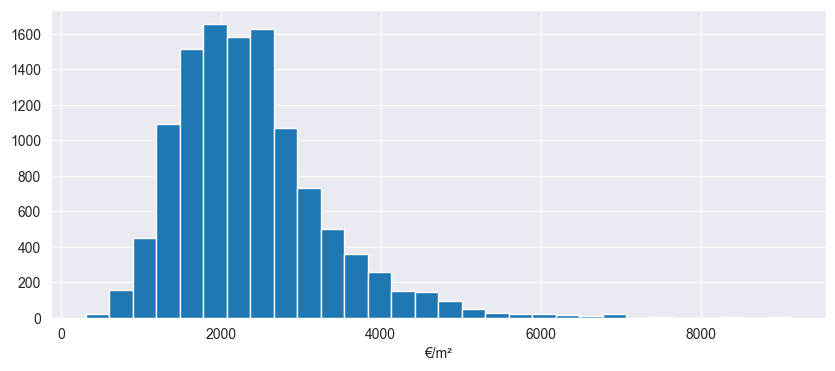

In [29]:
fig, ax = plt.subplots(figsize=(10,4))

ax.hist(data['square_price'], bins=30)
ax.set_xlabel('€/m²')

plt.show()

#### Price analysis in other locations

Locations such as mountains and spa-s are very popular in real-estate market. There are several popular locations like this in Serbia, including Kopaonik and Zlatibor mountain and Vrnjacka Banja and Sokobanja spa-s (where thermomineral springs are located)

In [30]:
other_locations = data[data['city'].isin(['Kopaonik', 'Vrnjačka Banja', 'Zlatibor', 'Sokobanja'])]

Let's see how many rows we have for each of those locations in dataset and average price

In [31]:
other_locations.groupby('city')['square_price'].agg(['mean','count']).sort_values(by='mean',ascending=False)

,mean,count
city,,
Kopaonik,2574.317708,192
Zlatibor,2028.581994,311
Vrnjačka Banja,1821.647059,306
Sokobanja,1812.000000,17


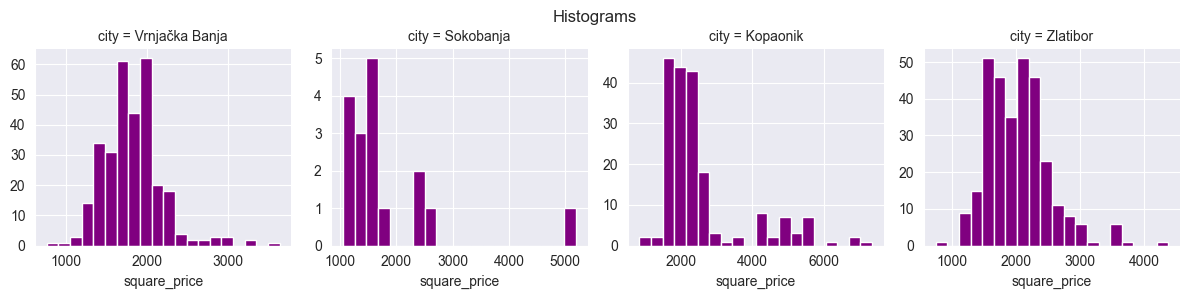

In [32]:
g = sb.FacetGrid(other_locations, col='city', col_wrap=4, sharex=False, sharey=False, height=3)
g.map(plt.hist, 'square_price', bins=20, color='purple')

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Histograms')
plt.show()

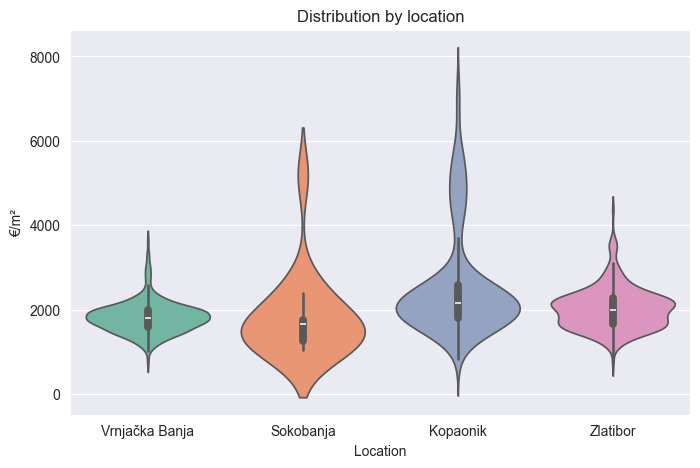

In [33]:
plt.figure(figsize=(8, 5))
sb.violinplot(data=other_locations, x='city', y='square_price', hue='city', palette='Set2')

plt.title('Distribution by location')
plt.xlabel('Location')
plt.ylabel('€/m²')
plt.show()

Here are the observations:
* Kopaonik has high variance in prices. We can see 2 accumulation points, around 2000 and 5000. There are less apartments with price 3000-4000 €/m².
* Vrnjacka banja has low variance and symmetric distribution around mean of 1800.

#### Average square price in cities

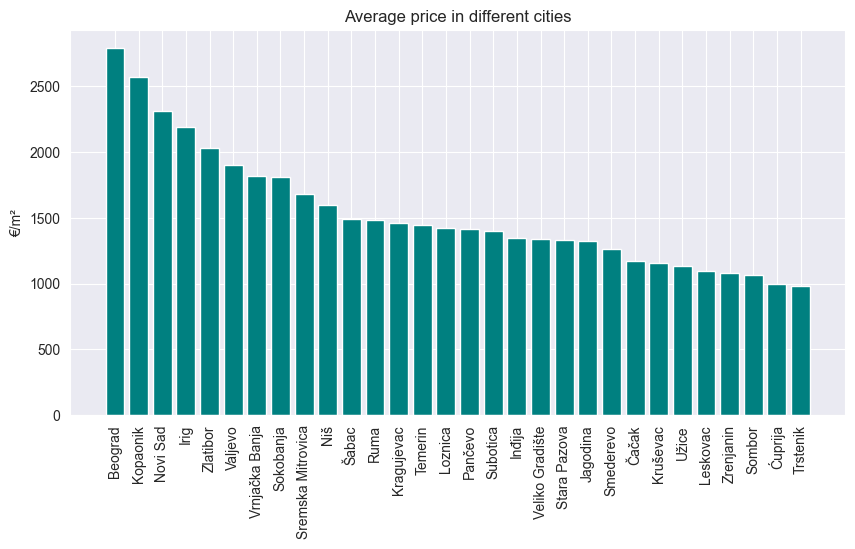

In [34]:
average_price = data.groupby('city').square_price.agg(['mean', 'count'])
average_price = average_price.loc[average_price['count'] > 7, :]
average_price.sort_values(by='mean', ascending=False, inplace=True)
x = average_price.index.tolist()
y = average_price['mean'].tolist()

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x,y, color='teal')
ax.set_title('Average price in different cities')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('€/m²')

plt.show()

## Square price distribution in main cities

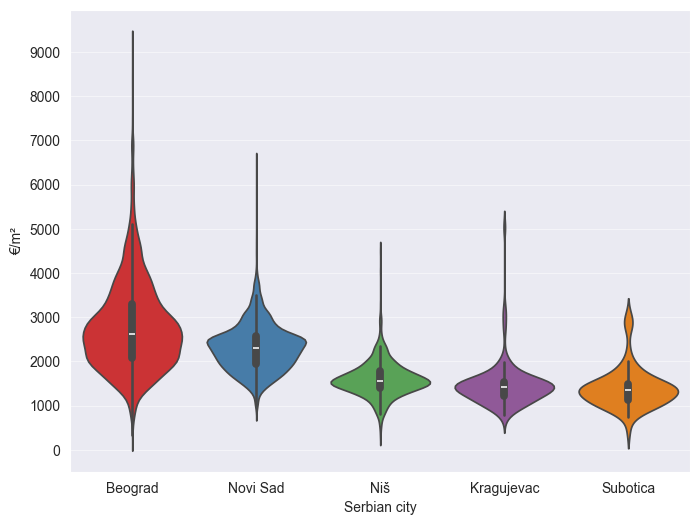

In [35]:
main_cities = data.loc[data['city'].isin(['Niš', 'Novi Sad', 'Beograd', 'Kragujevac', 'Subotica'])]

fig, ax = plt.subplots(figsize=(8,6))

sb.violinplot(ax=ax, data=main_cities, x='city', y='square_price', hue='city', palette='Set1')
ax.set_xlabel('Serbian city')
ax.set_ylabel('€/m²')
ax.grid(True, 'major', axis='y', alpha=0.5)
ax.set_yticks(range(0,10000, 1000))
plt.show()

Belgrade prices have very high variance compared to other cities

## Square price in parts of Belgrade

Square meter price in some belgrade municipalities

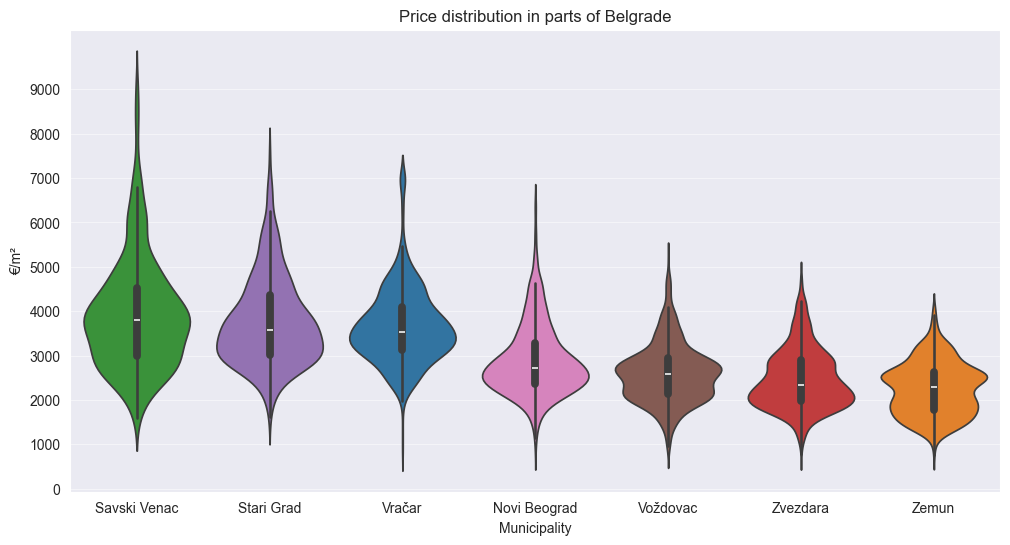

In [36]:
belgrade = data.loc[(data['city'] == 'Beograd') & data['opstina'].isin(['Savski Venac', 'Voždovac', 'Vračar', 'Novi Beograd', 'Stari Grad', 'Zvezdara', 'Zemun'])]
order = belgrade.groupby('opstina')['square_price'].mean().sort_values(ascending=False).index
fig, ax = plt.subplots(figsize=(12,6))

sb.violinplot(ax=ax, data=belgrade, order=order,  x='opstina', y='square_price', hue='opstina', palette='tab10')
ax.set_title('Price distribution in parts of Belgrade')
ax.set_ylabel('€/m²')
ax.set_xlabel('Municipality')
ax.grid(True, 'major', axis='y', alpha=0.5)
ax.set_yticks(range(0,10000, 1000))
plt.show()

Here is what we can conclude:
* municipality Savski Venac has very high variance in values
* municipalities Savski Venac, Stari Grad, Vracar and Novi Beograd are skewed towards higher values

## Plotting average square price per municipality

We will group data by opstina (municipality), calculate mean square_square price and count number of apartments for sale per opstina. Only opstina with count > 7 will be considered in this case.

In [37]:
mean_square_price = data.groupby('opstina').square_price.agg(['mean', 'count']).sort_values(by='count', ascending=False)
mean_square_price  = mean_square_price .loc[mean_square_price ['count'] > 7]
mean_square_price

,mean,count
opstina,,
Novi Sad,2315.002880,3125
Voždovac,2598.821384,795
Novi Beograd,2897.754453,786
Zvezdara,2465.493386,756
Niš,1633.903874,697
Palilula,2166.900312,642
Vračar,3661.267361,576
Zemun,2262.304878,574
Savski Venac,3932.400000,455


In [38]:
serbia = gpd.read_file(DATA_DIR / 'shapefiles' / 'gadm41_SRB_2.shp')
serbia = serbia.merge(mean_square_price, how='left', left_on='NAME_2', right_on='opstina')

temp = serbia[['NAME_2', 'mean', 'count']].dropna().copy()
temp.sort_values(by='mean', ascending=False, inplace=True)

Top 10 most expensive municipalities

In [39]:
temp.head(10)

,NAME_2,mean,count
21,Savski Venac,3932.400000,455.0
23,Stari Grad,3768.559420,345.0
26,Vračar,3661.267361,576.0
17,Novi Beograd,2897.754453,786.0
25,Voždovac,2598.821384,795.0
101,Brus,2574.317708,192.0
28,Zvezdara,2465.493386,756.0
13,Čukarica,2388.801075,372.0
40,Novi Sad,2315.002880,3125.0
27,Zemun,2262.304878,574.0


Top 10 cheapest municipalities

**NOTE**: there is no data for numerous municipalities that are mostly rural regions. Prices in municipalities that are mostly rural are usually cheaper on average compared to data showed below.

In [40]:
temp.tail(10)

,NAME_2,mean,count
91,Smederevo,1259.615385,13.0
69,Čačak,1171.947368,19.0
103,Kruševac,1156.657895,38.0
160,Užice,1137.272727,11.0
32,Leskovac,1097.615385,26.0
124,Zrenjanin,1077.920635,63.0
150,Sombor,1062.414634,41.0
94,Ćuprija,1000.500000,14.0
104,Trstenik,979.125000,8.0
12,Barajevo,833.181818,11.0


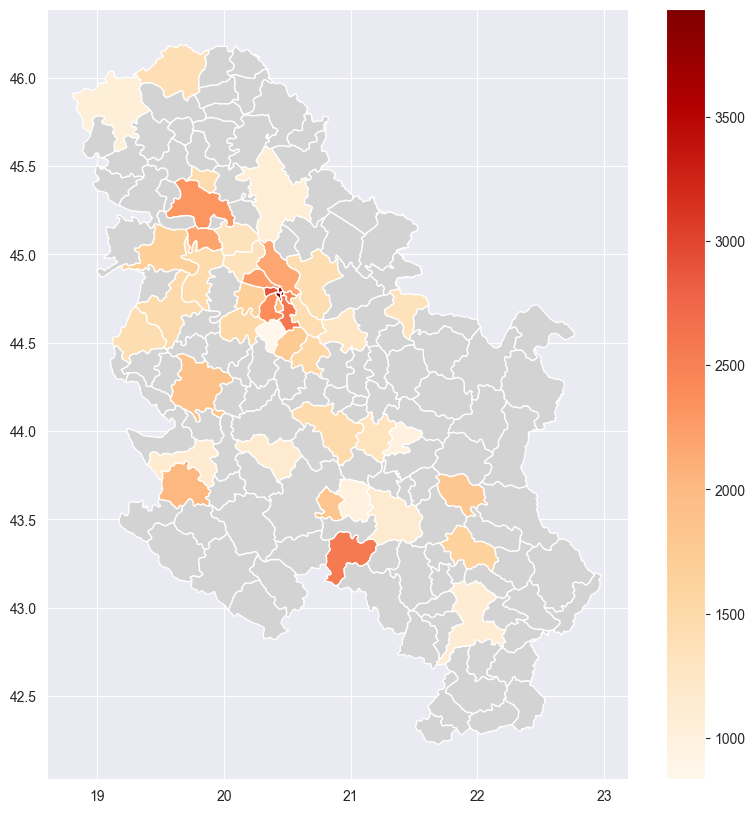

In [41]:

fig, ax = plt.subplots(figsize=(10, 10))

serbia.plot(ax=ax, column='mean', cmap='OrRd', legend=True, linewidth=1, missing_kwds={
    'color': 'lightgrey',
    'label': 'missing values'
})

plt.show()

Looking at this map, we can conclude the following:
* Belgrade city center is within most expensive regions in Serbia
* Other expensive regions: Novi Sad (including Petrovaradin and Sremski Karlovci microlocations), Brus (Kopaonik mountain has very expensive apartments, and they are mosty part of Brus), Čajetina (mainly Zlatibor mountain), Valjevo
* Cheap regions: Trstenik, Ćuprija, Sombor, Zrenjanin, Leskovac, Barajevo (Belgrade municipality)

## Belgrade apartment sale analysis

In [42]:
beograd = serbia[serbia['NAME_1'] == 'Grad Beograd']
beograd[['NAME_2', 'mean', 'count']]

,NAME_2,mean,count
12,Barajevo,833.181818,11.0
13,Čukarica,2388.801075,372.0
14,Grocka,1428.361111,36.0
15,Lazarevac,NaN,NaN
16,Mladenovac,1535.607143,28.0
17,Novi Beograd,2897.754453,786.0
18,Obrenovac,1530.047619,21.0
19,Palilula,2166.900312,642.0
20,Rakovica,1943.076087,276.0
21,Savski Venac,3932.400000,455.0


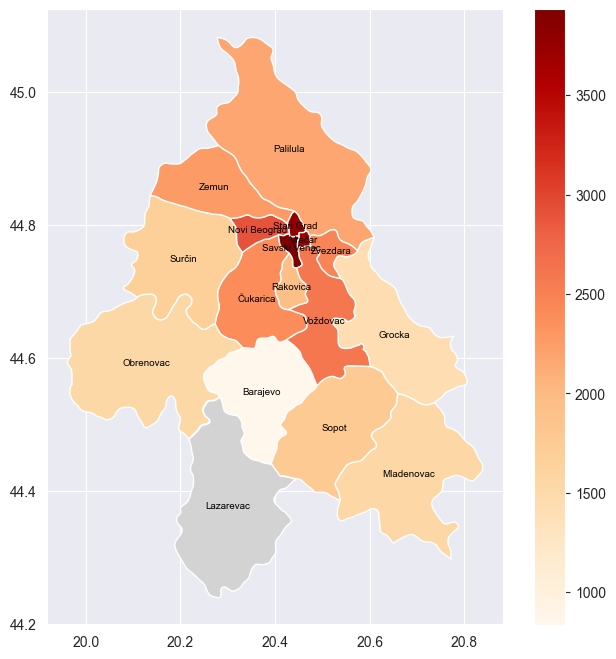

In [43]:
fig, ax = plt.subplots(figsize=(8,8))

beograd.plot(ax=ax, column='mean', cmap='OrRd', legend=True, edgecolor='white', missing_kwds={
    'color': 'lightgrey',
    'label': 'missing values'
})

for idx, row in beograd.iterrows():
    if row['geometry'] is None:
        continue
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    ax.text(
        x, y,
        row['NAME_2'],
        fontsize=7,
        ha='center',
        va='center',
        color='black'
    )
# add names on municipaly
plt.show()

## Plotting data on map

As mentioned before, this dataset does not include coordinates of locations, but we need them for next step.

In this case, we will roughly estimate coordinates using geopy. The idea is to extract relevant information from dataset (in this case data from city and location) and use geopy to calculate coordinates. To do so, we have to create location string that best suites geopy geocoder while trying to keep as much location information as possible.

In [44]:
geolocator = Nominatim(user_agent='myapp')
bad_tokens = ['gradska lokacija', 'okolno mesto', 'planina', 'centar', 'gradske lokacije']

import time
from unidecode import unidecode
import re
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

MAX_ATTEMPTS = 1 # max number of attempts per location
SLEEP_BETWEEN = 0 # wait time between attempts
STALL_TIMEOUT = 10 # max wait time in seconds

# clean location string (remove things that could make geocoding harder)
def clean_location(loc):
    parts = [p.strip().lower() for p in loc.split(',') if p.strip() != '']
    new = []
    for part in parts:
        if part in bad_tokens:
            continue
        temp = part.replace('opština', '').strip()
        temp = temp.replace('centar', '').strip()
        temp = re.sub(r'\(.*\)', '', temp)
        temp = temp.split('-')[0].strip()
        temp = unidecode(temp)
        if temp.title() not in new:
            new.append(temp.title())
    return ', '.join(new)

# using row from dataset, calculate latitude and longitude by prompitng geopy api
def find_coordinates(row):
    def try_geocode(q):
        for attempt in range(1, MAX_ATTEMPTS + 1):
            start = time.time()
            try:
                loc = geolocator.geocode(q, timeout=STALL_TIMEOUT)
                if loc:
                    return loc.latitude, loc.longitude
            except (GeocoderTimedOut, GeocoderServiceError) as e:
                print(f"⏱️ timeout/geoservice error: {e} attempt: {attempt})")
            except Exception as e:
                print(f"ERROR: {e} attempt: {attempt})")
            if time.time() - start > STALL_TIMEOUT * 2:
                print("Time limit exceeded, return None")
                return None
            time.sleep(SLEEP_BETWEEN)
        return None
    # =================================================================
    search_str = ', '.join(['Srbija', row['city'], row['location']])
    search_str = clean_location(search_str)
    print(f"Searching:", search_str)

    # if string is for example: Srbija, Novi Sad it is not precise enough
    if len(search_str.split(',')) <= 2:
        print("Not found ❌")
        return None
    try:
        loc = try_geocode(search_str)
        if loc:
            print("Found ✅")
            return loc

        # try without last part
        without_last = [p.strip() for p in search_str.split(',') if p.strip() != '']
        without_last = without_last[:-1]
        without_last_str = ', '.join(without_last)
        print("Try without last:", without_last_str)
        if len(without_last_str.split(',')) <= 2:
            print("Not found ❌")
            return None
        loc = try_geocode(without_last)
        if loc:
            print("Found ✅")
            return loc
        print("Not found ❌")
    except Exception as e:
        print("ERROR:", e)
    return None

The following code will create new dataset that has 2 additional columns - latitude and longitude (coordinates) and has rows in which city is "Beograd".

**NOTE:** depending on sample size this process can take long time since api only allows 1 request per second. For 800 locations it might take around 15min. For all belgrade locations (5000+) it might take more than hour. You can use precomputed datasets bg_coords.csv and ns_coords.csv, or adjust sample size and run this cell yourself.

In [45]:
def get_coords(row):
    coords = find_coordinates(row)
    return pd.Series(coords if coords is not None else [None, None])

Calculate coordinates for Belgrade

In [46]:
CALC_BG_COORDS = False # set true if you want to run
if CALC_BG_COORDS:
    bg_coords = data.loc[data['city'] == 'Beograd'].sample(800).copy()
    bg_coords[['latitude', 'longitude']] = bg_coords.apply(get_coords,axis=1)
    bg_coords.dropna(inplace=True)
    bg_coords = bg_coords.drop_duplicates(subset=['latitude', 'longitude'])
    bg_coords = bg_coords.reset_index(drop=True)
    bg_coords.to_csv(DATA_DIR / 'bg_coords.csv', index=False)

### Creating marker map using computed coordinates

Folium library will be used in this example

In [47]:
import folium
import matplotlib.colors as colors

#### Belgrade marker map and heatmap

Click on individual circles for more info

In [48]:

bg_coords_path = DATA_DIR / 'bg_coords.csv'
if not bg_coords_path.exists():
    stderr.write(f'{bg_coords_path} does not exist. Run cell above to create file\n')

bg_coords = pd.read_csv(DATA_DIR / 'bg_coords.csv')
min_price = bg_coords['square_price'].min()
max_price = bg_coords['square_price'].max()
norm = colors.Normalize(vmin=min_price, vmax=max_price)
cmap = plt.get_cmap('rainbow') # magma, twilight, YlOrRd, rainbow

# other possible tile styles: cartodbdark_matter, openstreetmap, mapquestopen
m = folium.Map(location=(44.75, 20.48), tiles="Cartodb Positron", zoom_start=11)

for i in range(bg_coords.shape[0]):
    row = bg_coords.iloc[i]
    coords = (row['latitude'], row['longitude'])
    price = row['square_price']

    if any(pd.isna(c) for c in coords):
        continue

    color = colors.to_hex(cmap(norm(price)))

    folium.Circle(
        location=coords,
        radius=150,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cena: {price:.0f} €/m², Kvadratura {row['area']}m²",
    ).add_to(m)
m

To spice things up, we can create a heatmap like this

In [49]:
from folium.plugins import HeatMap

hm_data = bg_coords.loc[:,['latitude', 'longitude', 'square_price']]
m = folium.Map(location=(44.75, 20.48), tiles="Cartodb Positron", zoom_start=11)
HeatMap(hm_data, radius=20, blur=25).add_to(m)
m

#### Novi Sad marker map

Same procedure as with Belgrade

In [50]:
CALC_NS_COORDS = False
if CALC_NS_COORDS:
    ns_coords = data.loc[data['city'] == 'Novi Sad'].sample(1000).copy()
    ns_coords[['latitude', 'longitude']] = ns_coords.apply(get_coords,axis=1)
    ns_coords.dropna(inplace=True)
    ns_coords = ns_coords.drop_duplicates(subset=['latitude', 'longitude'])
    ns_coords = ns_coords.reset_index(drop=True)
    ns_coords.to_csv(DATA_DIR / 'ns_coords.csv', index=False)

In [51]:
ns_coords_path = DATA_DIR / 'ns_coords.csv'
if not ns_coords_path.exists():
    stderr.write(f'{ns_coords_path} does not exist. Run cell above to create file\n')

ns_coords = pd.read_csv(DATA_DIR / 'ns_coords.csv')
min_price = ns_coords['square_price'].min()
max_price = ns_coords['square_price'].max()
norm = colors.Normalize(vmin=min_price, vmax=max_price)
cmap = plt.get_cmap('rainbow') # magma, twilight, YlOrRd, rainbow

m2 = folium.Map(location=(45.25, 19.84), tiles="Cartodb Positron", zoom_start=12)

for i in range(ns_coords.shape[0]):
    row = ns_coords.iloc[i]
    coords = (row['latitude'], row['longitude'])
    price = row['square_price']

    if any(pd.isna(c) for c in coords):
        continue

    color = colors.to_hex(cmap(norm(price)))

    folium.Circle(
        location=coords,
        radius=150,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cena: {price:.0f} €/m², Kvadratura {row['area']}m²",
    ).add_to(m2)
m2

This technique is not accurate and practical. When we used sample size 1000, we only got around 100 different locations in Novi Sad. As said before, main problem is in data accuracy with geopy geocoding.

## Apartment types analysis

In [52]:
luxury_aparmtnets = data.loc[data['title'].str.contains('lux')]
lux_avg_sp = luxury_aparmtnets['square_price'].mean()
lux_avg_area = luxury_aparmtnets['area'].mean()

In [53]:
novogradnja = data.loc[data['title'].str.contains('novogradnja')]
nvg_avg_sp = novogradnja['square_price'].mean()
nvg_avg_area = novogradnja['area'].mean()

In [54]:
renovated = data.loc[data['title'].str.contains('renoviran')]
rnv_avg_sp = renovated['square_price'].mean()
rnv_avg_area = renovated['area'].mean()

In [55]:
x = ['luxury', 'novogradnja', 'renovated']
y1 = [lux_avg_sp, nvg_avg_sp, rnv_avg_sp]
y2 = [lux_avg_area, nvg_avg_area, rnv_avg_area]

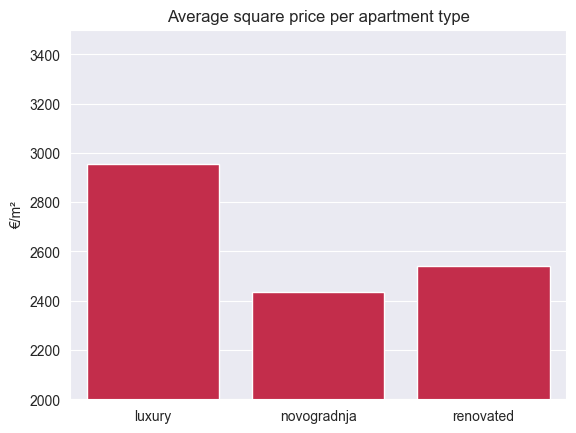

In [56]:
fig, ax = plt.subplots()
sb.barplot(x=x, y=y1, color='crimson', ax=ax)
ax.set_ylim(2000, 3500)
ax.set_title('Average square price per apartment type')
ax.set_ylabel('€/m²')
plt.show()

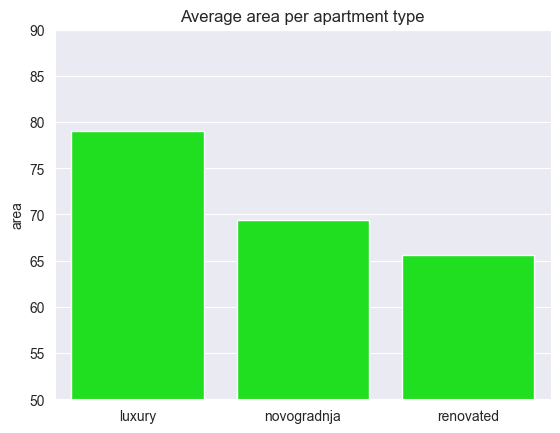

In [57]:
fig, ax = plt.subplots()
sb.barplot(x=x, y=y2, color='lime', ax=ax)
ax.set_ylim(50, 90)
ax.set_title('Average area per apartment type')
ax.set_ylabel('area')
plt.show()

Here is what we can conclude:
* luxury apartments have average price close to 3000 euros and average area close to 80 m2
* novogradnja apartments have average price close to 2400 euros and average area close to 70 m2
* renovated apartments have average price at around 2500 euros and average area around 65 m2

So, renovated apartments are on average more expensive than novogradnja. Luxury apartments are very sparse by area and are more expensive than novogradnja.

## Belgrade waterfront

In [74]:
bw = data.loc[data['title'].str.contains('bw|beograd na vodi', case=False)].copy()
bw

,area,city,floor,location,price,rooms,source,square_price,title,opstina
56,885,Beograd,p,"Opština Savski venac, Beograd na vodi, Herceg...",7310888,6.0,halooglasi,8263,"BW Riviera, stan sa bazenom ID#9324",Savski Venac
342,92,Beograd,16,"Opština Savski venac, Beograd na vodi",405000,3.0,halooglasi,4402,Extra Lux opremljen stan BW ARIA - bez provizije,Savski Venac
464,56,Beograd,2,"Opština Savski venac, Beograd na vodi, Savska",234000,2.0,halooglasi,4179,"BW Quartet 2, useljivo u junu 2024., bez provi...",Savski Venac
545,72,Beograd,2,"Opština Savski venac, Beograd na vodi, Saraje...",249550,3.0,halooglasi,3500,Beograd BW Sarajevska Bircaninova 71 + 6m2 Sal...,Savski Venac
623,40,Beograd,2,"Opština Savski venac, Beograd na vodi, BW Bella",201888,0.5,halooglasi,5047,BW Bella - bez provizije kupce!,Savski Venac
...,...,...,...,...,...,...,...,...,...,...
9809,28,Beograd,5,"Opština Savski venac, Beograd na vodi,",170000,0.5,halooglasi,6071,"Savski Venac (Beograd), Beograd na vodi, Stan,...",Savski Venac
11479,56,Beograd,6,"Beograd na vodi, Savski Venac",253888,2.0,4zida,4534,BW Echo,Savski Venac
11480,138,Beograd,5,"Beograd na vodi, Savski Venac",532888,4.0,4zida,3862,BW Quartet 4,Savski Venac
11482,55,Beograd,15,"Beograd na vodi, Savski Venac",269888,2.0,4zida,4907,BW Eden,Savski Venac


Ignore outlier from before

In [75]:
bw.drop(bw[bw['area'] > 800].index, inplace=True)
bw.describe()

,area,price,rooms,square_price
count,136.000000,1.360000e+02,136.000000,136.000000
mean,88.213235,4.274204e+05,2.827206,4834.639706
std,39.270837,2.386366e+05,1.031681,1045.463347
min,28.000000,1.700000e+05,0.500000,2618.000000
25%,55.000000,2.538880e+05,2.000000,4089.250000
50%,83.000000,3.724440e+05,3.000000,4534.000000
75%,112.000000,4.875000e+05,3.000000,5429.000000
max,219.000000,1.617000e+06,6.000000,8347.000000


Here is conclusion after looking at statistics:
* minimum area 28 m2, maximum area 219 m2, average area: 88 m2, median area: 83 m2
* minimum price: ~170.000e, maximum price: ~1.617.000e, average price: ~427.000e, median price: ~372.000e
* minimum square price: ~2600e, maximum square price: ~8300e, average square price: ~4800e, median square price: ~4500e

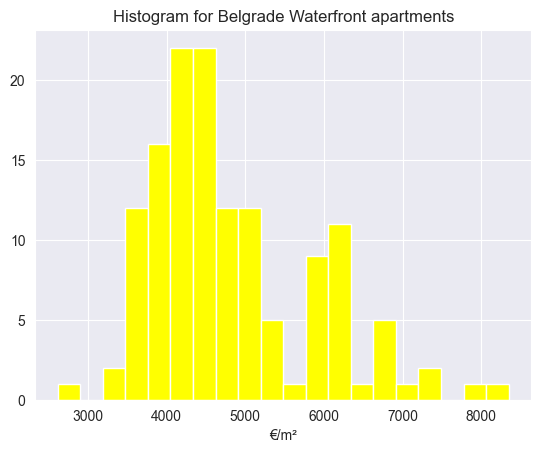

In [79]:
fig, ax = plt.subplots()
ax.hist(bw['square_price'], bins=20, color='yellow')
ax.set_xlabel('€/m²')
ax.set_title('Histogram for Belgrade Waterfront apartments')
plt.show()